###importing the required libraries and packages


In [ ]:
!pip install wget
import pandas as pd
import numpy as np
from  sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import datetime as dt
import wget
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
import math as m


loading and modifying the COVID-19 Timeseris analysis dataset and retrieving India Data



In [ ]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
[wget.download(url)]
confirmed_df=pd.read_csv('time_series_covid19_confirmed_global.csv')
india_cases=confirmed_df.loc[confirmed_df['Country/Region'] == 'India']
india_cases.iloc[:,4:]=india_cases.iloc[:,4:].astype('float64')


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,949,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192,2269,2330
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,761,762,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,58,60,61,69,70,70,71,74,81,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140,142,148,155,166,172,176,183,186,189,197,212,212,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,251,251,251,251,251,251,299,441,443,458,463,479,483,484,484,484,485,499,499,513,513,514,611,632,639,659,661,662,671,683,688,693,698,698,702,707,710,711,712,713
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,167,184,197,209,212,222,233,249,256,278,283,310,323,354,399,419,453,469,482,484,496,524,560,591,632,705,728,844,885,902,909,919,922,941,967,992,1015,1076,1089,1103
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,34,34,78,78,87,87,87,87,87,87,106,106,106,132,132,132,132,141,141,141,141,162,162,163,176,176,176,197,197,210,210,247,247,247,265,265,272,272,272
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1936,2140,2350,2551,2738,2929,3100,3266,3424,3563,3686,3807,3930,4013,4100,4191,4289,4370,4453,4529,4609,4690,4763,4834,4902,4971,5035,5097,5160,5221,5279,5338,5399,5457,5513,5567,5630,5691,5747,5799


In [ ]:
india_cases


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20
131,NaN,India,21.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,106475.0,112028.0,118226.0,124794.0,131423.0,138536.0,144950.0,150793.0,158086.0,165386.0,173491.0,181827.0,190609.0,198370.0,207191.0,216824.0,226713.0,236184.0,246622.0,257486.0,265928.0,276146.0,286605.0,297535.0,308993.0,320922.0,332424.0,343091.0,354065.0,366946.0,380532.0,395048.0,410451.0,425282.0,440215.0,456183.0,473105.0,490401.0,508953.0,528859.0


##Preprocessing of the Data

In [ ]:
def createFrame(dates):
    return india_cases.melt(id_vars=[], value_vars=dates,var_name='Date',value_name='Confirmed')


In [ ]:
india_cases_long=createFrame(india_cases.columns[4:])
india_cases_long['Date'] = pd.to_datetime(india_cases_long['Date'])
india_cases_long


,Date,Confirmed
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
153,2020-06-23,456183.0
154,2020-06-24,473105.0
155,2020-06-25,490401.0
156,2020-06-26,508953.0


<function matplotlib.pyplot.show>

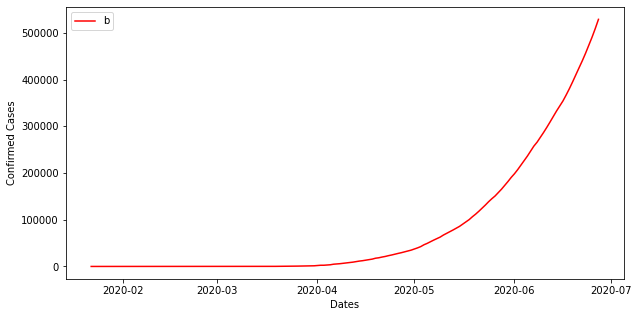

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(india_cases_long['Date'],india_cases_long['Confirmed'],color='red')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend('best')
plt.show

In [ ]:
train_size=int((len(india_cases.columns)-4)*0.8)
test_size=len(india_cases.columns)-4-train_size
train_size,test_size

(126, 32)

In [ ]:
train_frame=createFrame(india_cases.columns[4:train_size+4])
train_frame

,Date,Confirmed
0,1/22/20,0.0
1,1/23/20,0.0
2,1/24/20,0.0
3,1/25/20,0.0
4,1/26/20,0.0
...,...,...
121,5/22/20,124794.0
122,5/23/20,131423.0
123,5/24/20,138536.0
124,5/25/20,144950.0


In [ ]:
test_frame=createFrame(india_cases.columns[train_size+4:])
test_frame

,Date,Confirmed
0,5/27/20,158086.0
1,5/28/20,165386.0
2,5/29/20,173491.0
3,5/30/20,181827.0
4,5/31/20,190609.0
5,6/1/20,198370.0
6,6/2/20,207191.0
7,6/3/20,216824.0
8,6/4/20,226713.0
9,6/5/20,236184.0


In [ ]:
train_frame['Date'] = pd.to_datetime(train_frame['Date'])
train_dates=train_frame['Date']
train_frame['Date']=train_frame['Date'].map(dt.datetime.toordinal)
train_frame

,Date,Confirmed
0,737446,0.0
1,737447,0.0
2,737448,0.0
3,737449,0.0
4,737450,0.0
...,...,...
121,737567,124794.0
122,737568,131423.0
123,737569,138536.0
124,737570,144950.0


In [ ]:
test_frame['Date'] = pd.to_datetime(test_frame['Date'])
test_dates=test_frame['Date']
test_frame['Date']=test_frame['Date'].map(dt.datetime.toordinal)
test_frame

,Date,Confirmed
0,737572,158086.0
1,737573,165386.0
2,737574,173491.0
3,737575,181827.0
4,737576,190609.0
5,737577,198370.0
6,737578,207191.0
7,737579,216824.0
8,737580,226713.0
9,737581,236184.0


converting date feature format from string to the Georginal ordinal of a Date

In [ ]:
train_X=pd.DataFrame(train_frame['Date'])
train_X

,Date
0,737446
1,737447
2,737448
3,737449
4,737450
...,...
121,737567
122,737568
123,737569
124,737570


In [ ]:
train_y=pd.DataFrame(train_frame['Confirmed'])
train_y

,Confirmed
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
121,124794.0
122,131423.0
123,138536.0
124,144950.0


In [ ]:
test_X=pd.DataFrame(test_frame['Date'])
test_X

,Date
0,737572
1,737573
2,737574
3,737575
4,737576
5,737577
6,737578
7,737579
8,737580
9,737581


In [ ]:
test_y=pd.DataFrame(test_frame['Confirmed'])
test_y

,Confirmed
0,158086.0
1,165386.0
2,173491.0
3,181827.0
4,190609.0
5,198370.0
6,207191.0
7,216824.0
8,226713.0
9,236184.0


#Checking the lineraity in the data using Linear Regression Model

In [ ]:
lr_model=LinearRegression()
lr_model.fit(train_X,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<function matplotlib.pyplot.show>

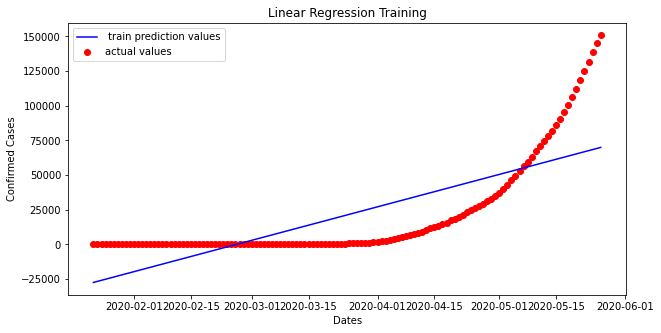

In [ ]:
lr_train_prediction=lr_model.predict(train_X)
plt.figure(figsize=(10,5))
plt.plot(train_dates,lr_train_prediction,color='blue',label=" train prediction values")
plt.scatter(train_dates,train_y,color='red', label="actual values")
plt.title('Linear Regression Training')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show


<function matplotlib.pyplot.show>

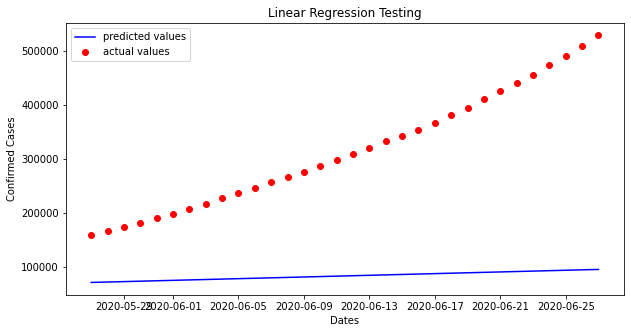

In [ ]:
lr_test_predictions=lr_model.predict(test_X)
plt.figure(figsize=(10,5))

plt.scatter(test_dates,test_y,color='red', label='actual values')
plt.plot(test_dates,lr_test_predictions,color='blue', label='predicted values')
plt.title('Linear Regression Testing')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show

In [ ]:
lr_test_predictions

array([[70732.14806354],
       [71511.4519825 ],
       [72290.75590146],
       [73070.05982053],
       [73849.36373949],
       [74628.66765857],
       [75407.97157753],
       [76187.2754966 ],
       [76966.57941556],
       [77745.88333464],
       [78525.18725359],
       [79304.49117255],
       [80083.79509163],
       [80863.09901059],
       [81642.40292966],
       [82421.70684862],
       [83201.0107677 ],
       [83980.31468666],
       [84759.61860573],
       [85538.92252469],
       [86318.22644365],
       [87097.53036273],
       [87876.83428168],
       [88656.13820076],
       [89435.44211972],
       [90214.74603879],
       [90994.04995775],
       [91773.35387671],
       [92552.65779579],
       [93331.96171474],
       [94111.26563382],
       [94890.56955278]])

In [ ]:
lr_error=mean_squared_error(lr_test_predictions,test_y)
print(lr_error)

64699658463.982895


#Implementation of  Random Forest Regressor Model


In [ ]:
rf_model=RandomForestRegressor()
rf_model.fit(train_X,train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

<function matplotlib.pyplot.show>

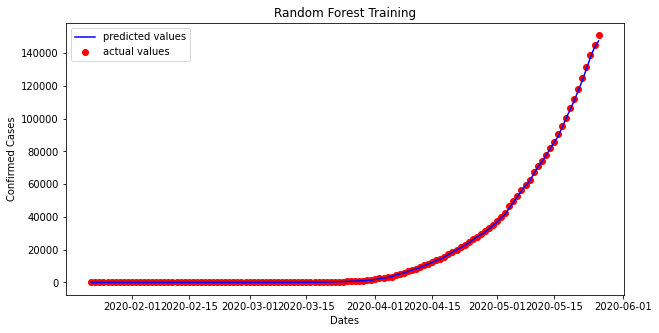

In [ ]:
rf_train_predictions=rf_model.predict(train_X)
plt.figure(figsize=(10,5))
plt.scatter(train_dates,train_y,color='red',label='actual values')
plt.plot(train_dates,rf_train_predictions,color='blue',label='predicted values')
plt.title('Random Forest Training')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show>

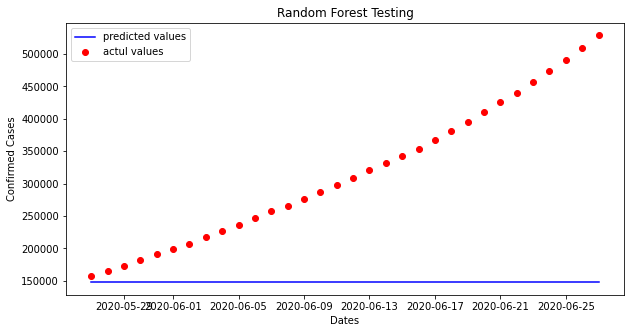

In [ ]:
rf_test_predictions=rf_model.predict(test_X)
plt.figure(figsize=(10,5))
plt.scatter(test_dates,test_y,color='red',label='actul values')
plt.plot(test_dates,rf_test_predictions,color='blue',label='predicted values')
plt.title('Random Forest Testing')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show

In [ ]:
rf_test_predictions

array([147397.04, 147397.04, 147397.04, 147397.04, 147397.04, 147397.04,
       147397.04, 147397.04, 147397.04, 147397.04, 147397.04, 147397.04,
       147397.04, 147397.04, 147397.04, 147397.04, 147397.04, 147397.04,
       147397.04, 147397.04, 147397.04, 147397.04, 147397.04, 147397.04,
       147397.04, 147397.04, 147397.04, 147397.04, 147397.04, 147397.04,
       147397.04, 147397.04])

In [ ]:
    rf_error=mean_squared_error(rf_test_predictions,test_y)
    rf_error

40208876110.42285

#Implementation of Polynomial Regression

In [ ]:
poly_scaler=PolynomialFeatures(degree=4)
poly_train_X=poly_scaler.fit_transform(train_X)


In [ ]:
Plr_model=LinearRegression()
Plr_model.fit(poly_train_X,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<function matplotlib.pyplot.show>

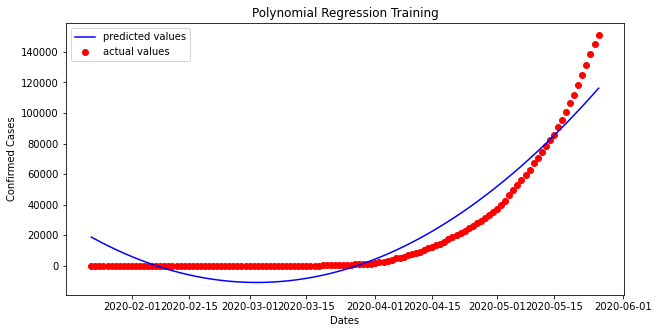

In [ ]:
Plr_train_predictions=Plr_model.predict(poly_train_X)
plt.figure(figsize=(10,5))
plt.scatter(train_dates,train_y,color='red',label='actual values')
plt.plot(train_dates,Plr_train_predictions,color='blue',label='predicted values')
plt.title('Polynomial Regression Training')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show>

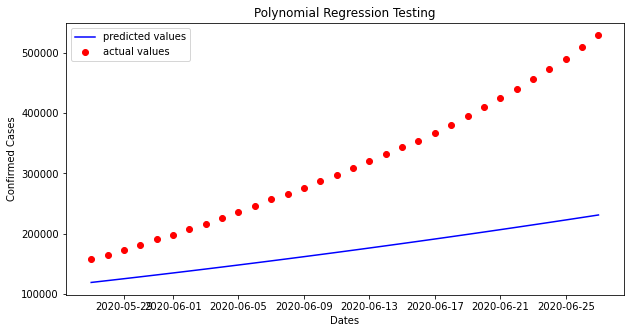

In [ ]:
Plr_test_predictions=Plr_model.predict(poly_scaler.transform(test_X))
plt.figure(figsize=(10,5))
plt.scatter(test_dates,test_y,color='red',label='actual values')
plt.plot(test_dates,Plr_test_predictions,color='blue',label='predicted values')
plt.title('Polynomial Regression Testing')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show

In [ ]:
Plr_test_predictions

array([[119232.66357422],
       [122303.49072266],
       [125410.13134766],
       [128552.58349609],
       [131730.84716797],
       [134944.92626953],
       [138194.81787109],
       [141480.52294922],
       [144802.04345703],
       [148159.37548828],
       [151552.52392578],
       [154981.48486328],
       [158446.26123047],
       [161946.85107422],
       [165483.25634766],
       [169055.47802734],
       [172663.51318359],
       [176307.36572266],
       [179987.03271484],
       [183702.51513672],
       [187453.81494141],
       [191240.93017578],
       [195063.86181641],
       [198922.61083984],
       [202817.17626953],
       [206747.55810547],
       [210713.75634766],
       [214715.77294922],
       [218753.60791016],
       [222827.25927734],
       [226936.72998047],
       [231082.02001953]])

In [ ]:
Plr_model_error=mean_squared_error(Plr_test_predictions,test_y)
Plr_model_error

26318545363.937443

#Implementation of LSTM Neural Network

In [ ]:
train_scaler=MinMaxScaler(feature_range=(0, 1))
test_scaler=MinMaxScaler(feature_range=(0,1))


In [ ]:
train_scaled=train_scaler.fit_transform(train_y)
test_scaled=test_scaler.fit_transform(test_y)

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
def lstmNeuralNet():

    model = Sequential()
    model.add(LSTM(10,input_shape=(1, look_back)))
    model.add(Dropout(0.2))

    model.add(Dense(1))


    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

In [ ]:
lstm_model=lstmNeuralNet()
lstm_model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 1s - loss: 0.0567
Epoch 2/100
 - 0s - loss: 0.0444
Epoch 3/100
 - 0s - loss: 0.0370
Epoch 4/100
 - 0s - loss: 0.0287
Epoch 5/100
 - 0s - loss: 0.0229
Epoch 6/100
 - 0s - loss: 0.0167
Epoch 7/100
 - 0s - loss: 0.0113
Epoch 8/100
 - 0s - loss: 0.0067
Epoch 9/100
 - 0s - loss: 0.0038
Epoch 10/100
 - 0s - loss: 0.0033
Epoch 11/100
 - 0s - loss: 0.0016
Epoch 12/100
 - 0s - loss: 0.0015
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0011
Epoch 15/100
 - 0s - loss: 0.0017
Epoch 16/100
 - 0s - loss: 0.0022
Epoch 17/100
 - 0s - loss: 0.0028
Epoch 18/100
 - 0s - loss: 0.0013
Epoch 19/100
 - 0s - loss: 0.0020
Epoch 20/100
 - 0s - loss: 0.0021
Epoch 21/100
 - 0s - loss: 0.0026
Epoch 22/100
 - 0s - loss: 0.0013
Epoch 23/100
 - 0s - loss: 0.0031
Epoch 24/100
 - 0s - loss: 0.0014
Epoch 25/100
 - 0s - loss: 0.0027
Epoch 26/100
 - 0s - loss: 0.0014
Epoch 27/100
 - 0s - loss: 0.0012
Epoch 28/100
 - 0s - loss: 0.0019
Epoch 29/100
 - 0s - loss: 0.0032
Epoch 30/100
 - 0s - lo

In [ ]:
lstm_train_predictions=lstm_model.predict(trainX)
lstm_train_predictions=train_scaler.inverse_transform(lstm_train_predictions)


<function matplotlib.pyplot.show>

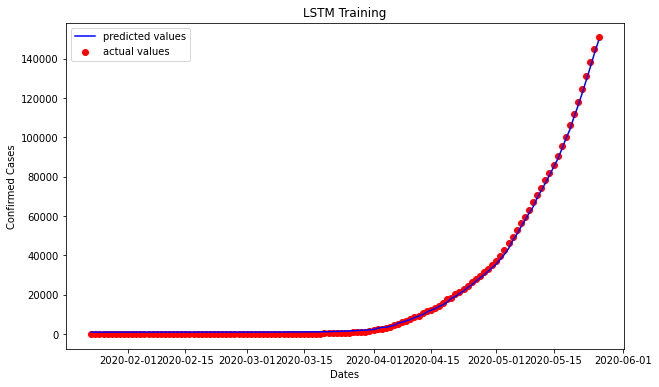

In [ ]:
plt.figure(figsize=(10,6))

plt.scatter(train_dates[1:len(train_dates)],train_y[1:len(train_y)],color='red',label='actual values')
plt.plot(train_dates[1:len(train_dates)],lstm_train_predictions,color='blue',label='predicted values')
plt.title('LSTM Training')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show

In [ ]:
lstm_test_predictions=test_scaler.inverse_transform(lstm_model.predict(testX))
lstm_test_predictions

array([[160424.17],
       [167416.97],
       [175244.88],
       [183363.33],
       [191986.8 ],
       [199665.17],
       [208454.33],
       [218123.61],
       [228121.78],
       [237760.42],
       [248448.6 ],
       [259638.58],
       [268375.2 ],
       [278992.28],
       [289901.53],
       [301339.47],
       [313362.28],
       [325904.53],
       [338012.53],
       [349246.22],
       [360799.97],
       [374346.66],
       [388604.44],
       [403787.94],
       [419823.84],
       [435173.22],
       [450520.94],
       [466795.38],
       [483867.38],
       [501109.94],
       [519349.6 ]], dtype=float32)

<function matplotlib.pyplot.show>

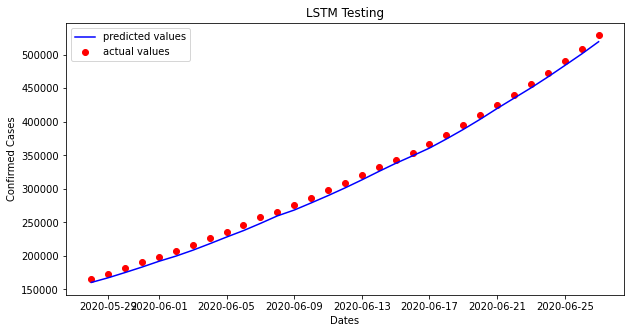

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(test_dates[1:len(test_dates)],test_y[1:len(test_y)],color='red',label='actual values')
plt.plot(test_dates[1:len(test_dates)],lstm_test_predictions,color='blue',label='predicted values')
plt.title('LSTM Testing')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show

In [ ]:
lstm_error=mean_squared_error(lstm_test_predictions,test_y[1:len(test_y)])

lstm_error

49381240.1688193

In [ ]:
print("RMSE cost function value of all the models are")
print("Linear Regression Model:",m.sqrt(lr_error))
print("Random Forest Model:",m.sqrt(rf_error))
print("Polynomial Regression:",m.sqrt(Plr_model_error))
print("LSTM Neural Network:",m.sqrt(lstm_error))

RMSE cost function value of all the models are
Linear Regression Model: 254361.27548033505
Random Forest Model: 200521.5103434613
Polynomial Regression: 162229.9151326211
LSTM Neural Network: 7027.178677735418


<function matplotlib.pyplot.show>

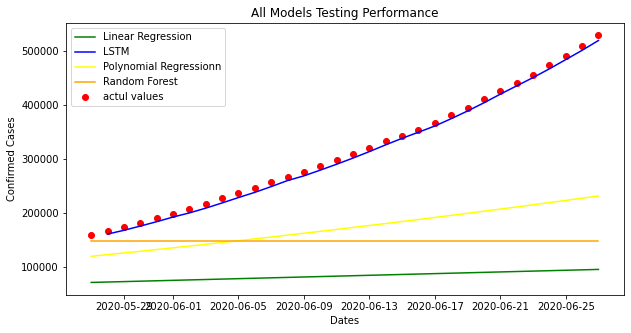

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(test_dates,test_y,color='red',label='actul values')
plt.plot(test_dates,lr_test_predictions,color='green', label='Linear Regression')
plt.plot(test_dates[1:len(test_dates)],lstm_test_predictions,color='blue',label='LSTM')
plt.plot(test_dates,Plr_test_predictions,color='yellow',label='Polynomial Regressionn')
plt.plot(test_dates,rf_test_predictions,color='orange',label='Random Forest')
plt.title('All Models Testing Performance')
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.legend(loc='best')
plt.show
